# MLP
Convert CNN_264 to an MLP.

More neurons.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-27 19:06:34.882924


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=100 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 19:07:07.524038
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16512     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,897
Trainable params: 24,897
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 19:07:07.812451
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 19:07:26.669926

Training # 1 1
2023-03-27 19:07:26.670146
2023-03-27 19:07:26.670201
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 19:07:26.728544


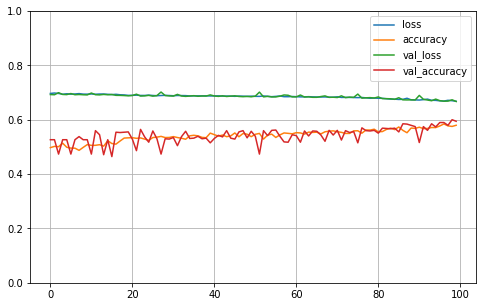


2023-03-27 19:08:49.866639

Testing # 1 1
2023-03-27 19:08:49.866743
2023-03-27 19:08:49.866782
PREDICT
2023-03-27 19:08:49.879729
Test 1:0 458:412 52.64%
Predict 1:0 581:289 66.78%
Test sizes (870, 257) (870,)
Range of scores: 0.095306404 to 0.76867294
Score threshold 0.5
Confusion matrix
 [[174 238]
 [115 343]]
Normalized matrix
 [[0.2        0.27356322]
 [0.13218391 0.39425287]]


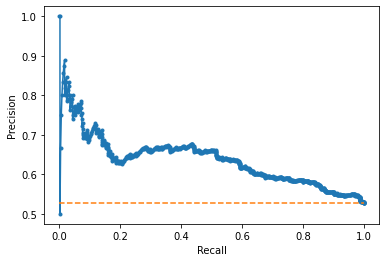

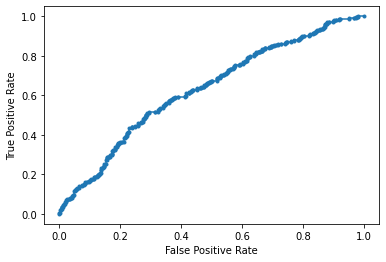

Accuracy: 59.43% Precision: 59.04% Recall: 74.89%
F1: 66.03% MCC: 0.1815
AUPRC: 63.71% AUROC: 63.05%
 accuracy [59.425287356321846]
 precision [59.036144578313255]
 recall [74.89082969432314]
 F1 [66.02502406159769]
 MCC [0.18152878696777108]
 AUPRC [63.705134260614884]
 AUROC [63.04797134014499]
2023-03-27 19:08:50.989210

Training # 1 2
2023-03-27 19:08:50.989655
2023-03-27 19:08:50.989705
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 19:08:51.050190


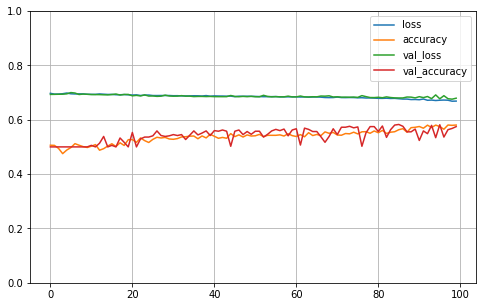


2023-03-27 19:10:14.001746

Testing # 1 2
2023-03-27 19:10:14.003216
2023-03-27 19:10:14.003665
PREDICT
2023-03-27 19:10:14.010525
Test 1:0 442:442 50.00%
Predict 1:0 722:162 81.67%
Test sizes (884, 257) (884,)
Range of scores: 0.10495666 to 0.8042897
Score threshold 0.5
Confusion matrix
 [[114 328]
 [ 48 394]]
Normalized matrix
 [[0.12895928 0.37104072]
 [0.05429864 0.44570136]]


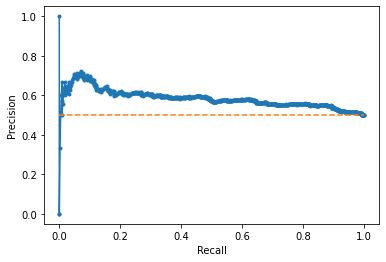

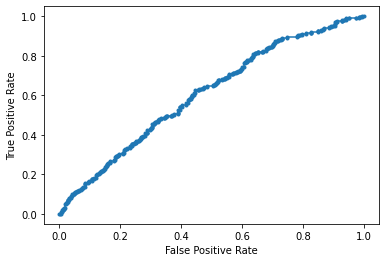

Accuracy: 57.47% Precision: 54.57% Recall: 89.14%
F1: 67.70% MCC: 0.1930
AUPRC: 58.36% AUROC: 60.82%
 accuracy [57.466063348416284]
 precision [54.57063711911358]
 recall [89.14027149321268]
 F1 [67.69759450171821]
 MCC [0.19298245614035087]
 AUPRC [58.364087324547334]
 AUROC [60.82082676439876]
2023-03-27 19:10:15.305702

Training # 1 3
2023-03-27 19:10:15.308336
2023-03-27 19:10:15.308723
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 19:10:15.402492


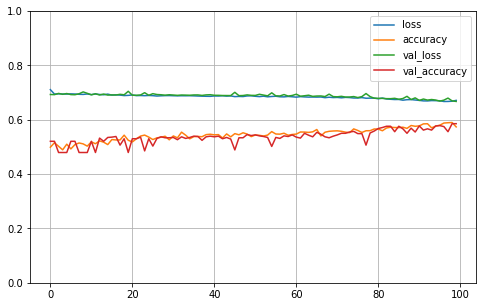


2023-03-27 19:10:53.803814

Testing # 1 3
2023-03-27 19:10:53.805508
2023-03-27 19:10:53.806039
PREDICT
2023-03-27 19:10:53.813644
Test 1:0 442:407 52.06%
Predict 1:0 544:305 64.08%
Test sizes (849, 257) (849,)
Range of scores: 0.116990134 to 0.8016426
Score threshold 0.5
Confusion matrix
 [[180 227]
 [125 317]]
Normalized matrix
 [[0.21201413 0.26737338]
 [0.14723204 0.37338045]]


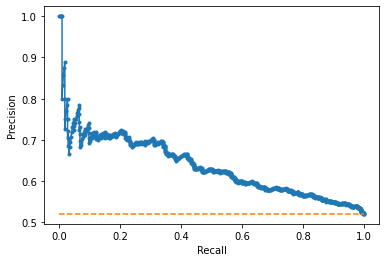

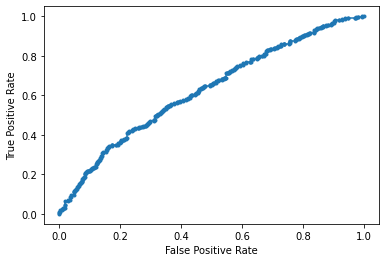

Accuracy: 58.54% Precision: 58.27% Recall: 71.72%
F1: 64.30% MCC: 0.1660
AUPRC: 63.73% AUROC: 62.68%
 accuracy [58.5394581861013]
 precision [58.27205882352941]
 recall [71.71945701357465]
 F1 [64.30020283975661]
 MCC [0.16603404381060666]
 AUPRC [63.728038889669406]
 AUROC [62.67635385282444]
2023-03-27 19:10:55.221619

Training # 1 4
2023-03-27 19:10:55.223327
2023-03-27 19:10:55.223380
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 19:10:55.282975


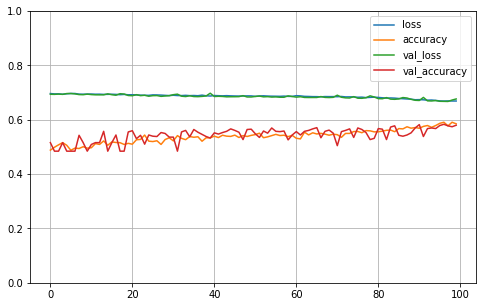


2023-03-27 19:11:40.027530

Testing # 1 4
2023-03-27 19:11:40.027625
2023-03-27 19:11:40.027661
PREDICT
2023-03-27 19:11:40.034374
Test 1:0 459:431 51.57%
Predict 1:0 781:109 87.75%
Test sizes (890, 257) (890,)
Range of scores: 0.10181875 to 0.8185082
Score threshold 0.5
Confusion matrix
 [[ 83 348]
 [ 26 433]]
Normalized matrix
 [[0.09325843 0.39101124]
 [0.02921348 0.48651685]]


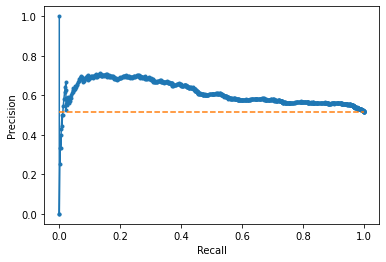

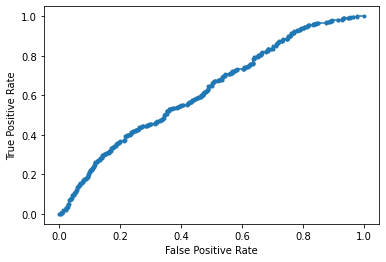

Accuracy: 57.98% Precision: 55.44% Recall: 94.34%
F1: 69.84% MCC: 0.2072
AUPRC: 61.37% AUROC: 62.47%
 accuracy [57.97752808988764]
 precision [55.44174135723432]
 recall [94.33551198257081]
 F1 [69.83870967741936]
 MCC [0.2072159632195167]
 AUPRC [61.36602496562023]
 AUROC [62.46556369389725]
2023-03-27 19:11:41.056556

Training # 1 5
2023-03-27 19:11:41.056704
2023-03-27 19:11:41.056749
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 19:11:41.119934


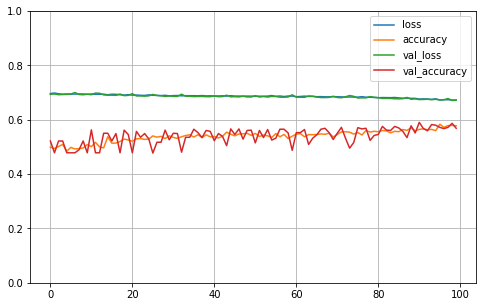


2023-03-27 19:12:26.627149

Testing # 1 5
2023-03-27 19:12:26.629004
2023-03-27 19:12:26.629428
PREDICT
2023-03-27 19:12:26.636189
Test 1:0 457:419 52.17%
Predict 1:0 413:463 47.15%
Test sizes (876, 257) (876,)
Range of scores: 0.102741174 to 0.6832192
Score threshold 0.5
Confusion matrix
 [[252 167]
 [211 246]]
Normalized matrix
 [[0.28767123 0.19063927]
 [0.24086758 0.28082192]]


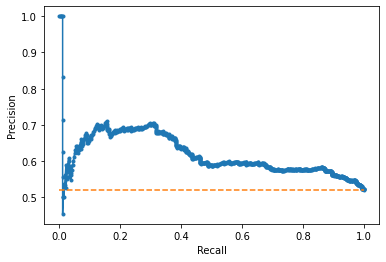

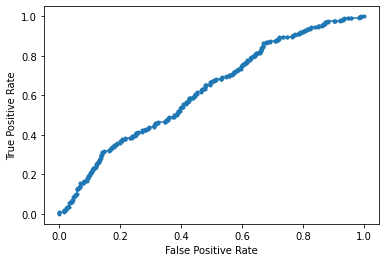

Accuracy: 56.85% Precision: 59.56% Recall: 53.83%
F1: 56.55% MCC: 0.1398
AUPRC: 62.01% AUROC: 62.31%
 accuracy [56.849315068493155]
 precision [59.56416464891041]
 recall [53.82932166301969]
 F1 [56.551724137931046]
 MCC [0.1398216176864757]
 AUPRC [62.00833950816722]
 AUROC [62.30579215909506]
2023-03-27 19:12:27.890664

Training # 2 1
2023-03-27 19:12:27.890827
2023-03-27 19:12:27.890873
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 19:12:27.953429


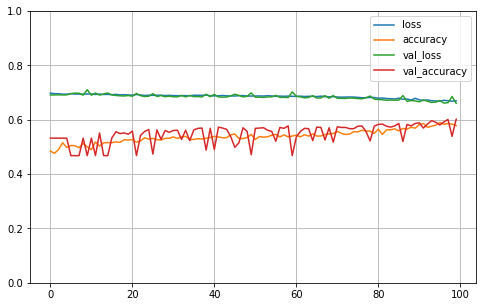


2023-03-27 19:13:50.809204

Testing # 2 1
2023-03-27 19:13:50.809505
2023-03-27 19:13:50.809557
PREDICT
2023-03-27 19:13:50.818623
Test 1:0 472:415 53.21%
Predict 1:0 633:254 71.36%
Test sizes (887, 257) (887,)
Range of scores: 0.094418325 to 0.8356602
Score threshold 0.5
Confusion matrix
 [[158 257]
 [ 96 376]]
Normalized matrix
 [[0.17812852 0.2897407 ]
 [0.10822999 0.42390079]]


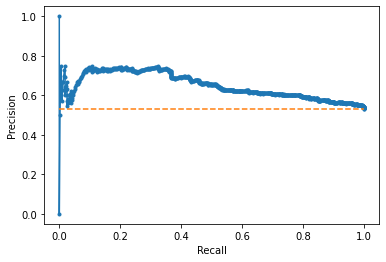

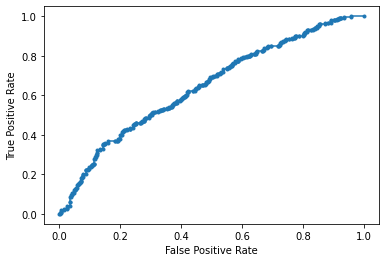

Accuracy: 60.20% Precision: 59.40% Recall: 79.66%
F1: 68.05% MCC: 0.1957
AUPRC: 64.91% AUROC: 64.46%
 accuracy [60.20293122886133]
 precision [59.3996840442338]
 recall [79.66101694915254]
 F1 [68.05429864253392]
 MCC [0.1957338980206123]
 AUPRC [64.91298626485305]
 AUROC [64.46344700837247]
2023-03-27 19:13:51.943542

Training # 2 2
2023-03-27 19:13:51.944413
2023-03-27 19:13:51.944461
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 19:13:52.003656


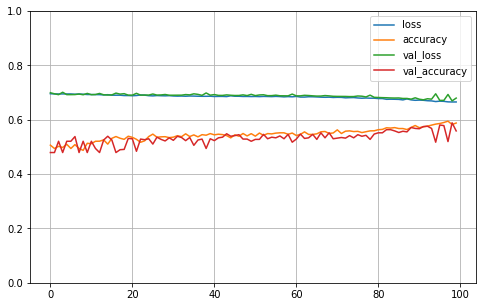


2023-03-27 19:14:37.826791

Testing # 2 2
2023-03-27 19:14:37.826887
2023-03-27 19:14:37.826922
PREDICT
2023-03-27 19:14:37.835719
Test 1:0 452:416 52.07%
Predict 1:0 195:673 22.47%
Test sizes (868, 257) (868,)
Range of scores: 0.0733983 to 0.7691346
Score threshold 0.5
Confusion matrix
 [[353  63]
 [320 132]]
Normalized matrix
 [[0.40668203 0.07258065]
 [0.36866359 0.15207373]]


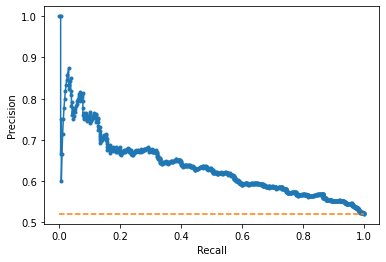

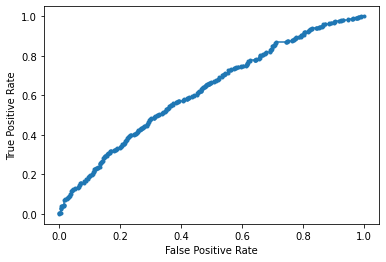

Accuracy: 55.88% Precision: 67.69% Recall: 29.20%
F1: 40.80% MCC: 0.1683
AUPRC: 63.50% AUROC: 62.47%
 accuracy [55.875576036866356]
 precision [67.6923076923077]
 recall [29.20353982300885]
 F1 [40.80370942812983]
 MCC [0.16828872599844863]
 AUPRC [63.50197640857442]
 AUROC [62.47181330837305]
2023-03-27 19:14:38.807634

Training # 2 3
2023-03-27 19:14:38.809341
2023-03-27 19:14:38.809394
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 19:14:38.870103


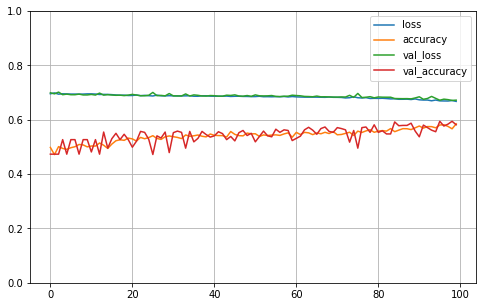


2023-03-27 19:15:23.424900

Testing # 2 3
2023-03-27 19:15:23.424999
2023-03-27 19:15:23.425038
PREDICT
2023-03-27 19:15:23.435002
Test 1:0 453:407 52.67%
Predict 1:0 507:353 58.95%
Test sizes (860, 257) (860,)
Range of scores: 0.08677875 to 0.7440915
Score threshold 0.5
Confusion matrix
 [[200 207]
 [153 300]]
Normalized matrix
 [[0.23255814 0.24069767]
 [0.17790698 0.34883721]]


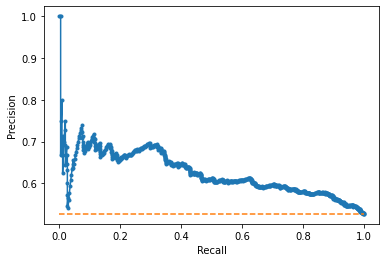

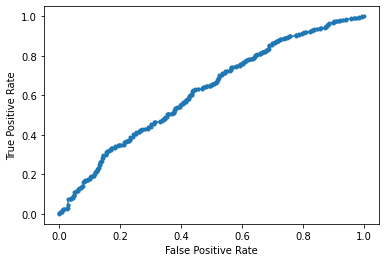

Accuracy: 58.14% Precision: 59.17% Recall: 66.23%
F1: 62.50% MCC: 0.1560
AUPRC: 62.51% AUROC: 62.22%
 accuracy [58.139534883720934]
 precision [59.171597633136095]
 recall [66.22516556291392]
 F1 [62.5]
 MCC [0.1559529543657512]
 AUPRC [62.50889120084063]
 AUROC [62.220197319535075]
2023-03-27 19:15:24.397418

Training # 2 4
2023-03-27 19:15:24.398201
2023-03-27 19:15:24.398248
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 19:15:24.459173


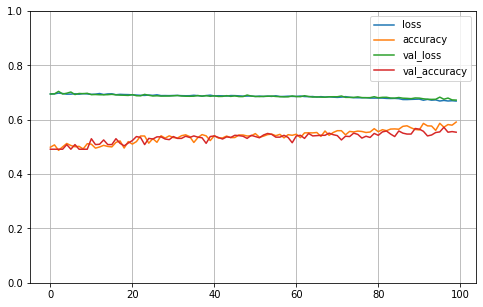


2023-03-27 19:16:10.553184

Testing # 2 4
2023-03-27 19:16:10.553310
2023-03-27 19:16:10.553350
PREDICT
2023-03-27 19:16:10.562129
Test 1:0 432:447 49.15%
Predict 1:0 566:313 64.39%
Test sizes (879, 257) (879,)
Range of scores: 0.08391129 to 0.7449012
Score threshold 0.5
Confusion matrix
 [[184 263]
 [129 303]]
Normalized matrix
 [[0.20932878 0.29920364]
 [0.14675768 0.3447099 ]]


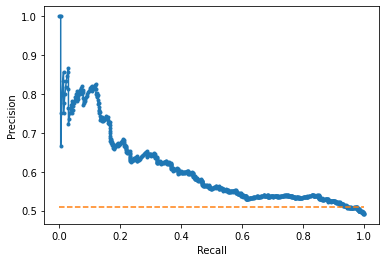

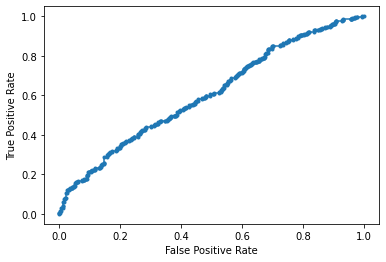

Accuracy: 55.40% Precision: 53.53% Recall: 70.14%
F1: 60.72% MCC: 0.1180
AUPRC: 60.55% AUROC: 60.70%
 accuracy [55.40386803185437]
 precision [53.53356890459364]
 recall [70.13888888888889]
 F1 [60.72144288577155]
 MCC [0.1179989745164606]
 AUPRC [60.54508690100029]
 AUROC [60.69838014748529]
2023-03-27 19:16:11.538386

Training # 2 5
2023-03-27 19:16:11.538561
2023-03-27 19:16:11.538608
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 19:16:11.603271


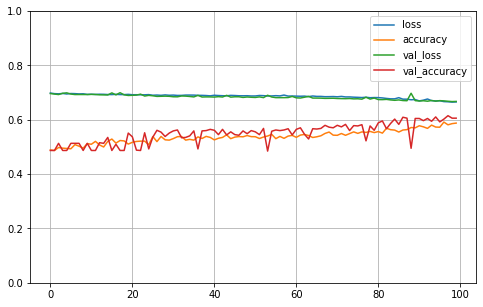


2023-03-27 19:16:56.827016

Testing # 2 5
2023-03-27 19:16:56.827570
2023-03-27 19:16:56.827610
PREDICT
2023-03-27 19:16:56.832908
Test 1:0 449:426 51.31%
Predict 1:0 640:235 73.14%
Test sizes (875, 257) (875,)
Range of scores: 0.11432499 to 0.8794228
Score threshold 0.5
Confusion matrix
 [[158 268]
 [ 77 372]]
Normalized matrix
 [[0.18057143 0.30628571]
 [0.088      0.42514286]]


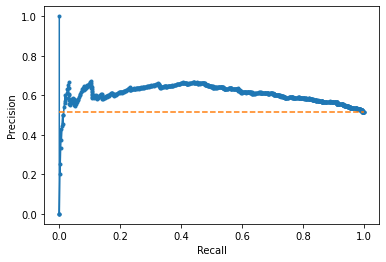

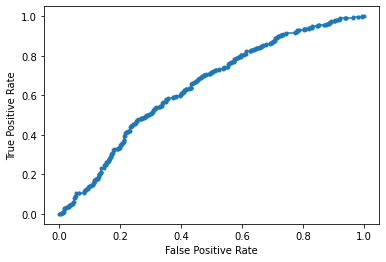

Accuracy: 60.57% Precision: 58.13% Recall: 82.85%
F1: 68.32% MCC: 0.2249
AUPRC: 60.71% AUROC: 64.43%
 accuracy [60.57142857142858]
 precision [58.12500000000001]
 recall [82.85077951002228]
 F1 [68.31955922865014]
 MCC [0.2248685919658493]
 AUPRC [60.710251307712994]
 AUROC [64.42956178048246]
2023-03-27 19:16:57.421246


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.05% std 1.72
 precision mean 58.48% std 3.90
 recall mean 71.20% std 18.77
 F1 mean 62.48% std 8.63
 MCC mean 0.18% std 0.03
 AUPRC mean 62.14% std 1.95
 AUROC mean 62.56% std 1.25
 accuracy [[59.425287356321846], [57.466063348416284], [58.5394581861013], [57.97752808988764], [56.849315068493155], [60.20293122886133], [55.875576036866356], [58.139534883720934], [55.40386803185437], [60.57142857142858]]
 precision [[59.036144578313255], [54.57063711911358], [58.27205882352941], [55.44174135723432], [59.56416464891041], [59.3996840442338], [67.6923076923077], [59.171597633136095], [53.53356890459364], [58.12500000000001]]
 recall [[74.89082969432314], [89.14027149321268], [71.71945701357465], [94.33551198257081], [53.82932166301969], [79.66101694915254], [29.20353982300885], [66.22516556291392], [70.13888888888889], [82.85077951002228]]
 F1 [[66.02502406159769], [67.69759450171821], [64.30020283975661], [69.83870967741936], [56.551724137931046], [68.05429864253392], [40